# Minimal example - Pytorch API

## Define nn.Module with feature extractor network

Notes:
* In the forward funcition one must define the `self.feature_maps = [some_tensor, another_tensor]` parameter. This parameter is used by the `PytorchReceptiveField` to get the desired feature maps. 
* The feature_maps is a list of tensors of shape [batch_size, num_channels, height, width].

In [102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
import torch
import torch.nn as nn

class Linear(nn.Module):
    """An identity activation function"""
    def forward(self, x):
        return x
    

class SimpleVGG(nn.Module):
    def __init__(self, disable_activations: bool = True):
        """disable_activations: whether to generate network with Relus or not."""
        super(SimpleVGG, self).__init__()
        self.features = self._make_layers(disable_activations)

    def forward(self, x):
        # index of layers with feature maps
        select = [8,13]
        # self.feature_maps is a list of Tensors, PytorchReceptiveField looks for 
        # this parameter and compute receptive fields for Tensors in self.feature_maps.
        self.feature_maps = []
        for l, layer in enumerate(self.features):
            x = layer(x)
            if l in select:
                self.feature_maps.append(x)
        return x

    def _make_layers(self, disable_activations: bool):
        activation = lambda: Linear() if disable_activations else nn.ReLU()
        layers = [
            nn.Conv2d(3, 64, kernel_size=3),
            activation(),
            nn.Conv2d(64, 64, kernel_size=3),
            activation(),
            
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            activation(),
            nn.Conv2d(128, 128, kernel_size=3),
            activation(), # 8
            
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3),
            activation(),
            nn.Conv2d(256, 256, kernel_size=3),
            activation(), # 13
        ]        
        return nn.Sequential(*layers)    

In [104]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, stride, plugin):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, inplanes, stride)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU()
        self.conv2 = conv3x3(inplanes, inplanes)
        self.bn2 = nn.BatchNorm2d(inplanes)
        self.downsample = lambda x: x
        self.stride = stride
        self.plugin = plugin(inplanes, inplanes)

    def forward(self, x):
        residual = self.downsample(x)
        self.feature_maps = []
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.plugin(out)
        self.feature_maps.append(out)
        out = out + residual
        out = self.relu(out)
        return out

In [105]:
def conv3x3(in_channels, out_channels, stride=1, padding=1, dilation=1):
    """3x3 convolution"""
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        bias=False,
    )
class SPP(nn.Module):
    def __init__(self, c1, c2, k=(5, 9, 13)):
        super(SPP,self).__init__() 
        self.m = nn.ModuleList([
            nn.MaxPool2d(ki, stride=1, padding=ki//2) for ki in k
        ])

        self.conv = nn.Conv2d(c1 * 4, c2, 1, 1)

    def forward(self, x):
        return self.conv(torch.cat([x] + [m(x) for m in self.m], 1))

## Define model build function
Notes:
* In the case when using layers which behave differently on training and eval modes, it is recommended to set model to an eval mode: `model.eval()`

In [106]:
def model_fn() -> nn.Module:
    model = SimpleVGG(disable_activations=False)
    # model = BasicBlock(3, 1, SPP)
    model.eval()
    print(model)
    return model

## Run RF estimation

In [107]:
import sys 
import os 
sys.path.insert(0, "..")

from receptivefields.pytorch import PytorchReceptiveField

input_shape = [64, 64, 3]
rf = PytorchReceptiveField(model_fn)
rf_params = rf.compute(input_shape = input_shape) 

[2022-03-09 11:53:22,623][ INFO][pytorch.py]::Feature maps shape: [GridShape(n=1, w=26, h=26, c=128), GridShape(n=1, w=9, h=9, c=256)]
[2022-03-09 11:53:22,624][ INFO][pytorch.py]::Input shape       : GridShape(n=1, w=64, h=64, c=3)
[2022-03-09 11:53:22,700][ INFO][base.py]::Estimated receptive field for feature map [0]: ReceptiveFieldDescription(offset=(7.0, 7.0), stride=(2.0, 2.0), size=Size(w=14, h=14))
[2022-03-09 11:53:22,701][ INFO][base.py]::Estimated receptive field for feature map [1]: ReceptiveFieldDescription(offset=(16.0, 16.0), stride=(4.0, 4.0), size=Size(w=32, h=32))


SimpleVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
  )
)


In [108]:
rf.feature_maps_desc

[FeatureMapDescription(size=Size(w=26, h=26), rf=ReceptiveFieldDescription(offset=(7.0, 7.0), stride=(2.0, 2.0), size=Size(w=14, h=14))),
 FeatureMapDescription(size=Size(w=9, h=9), rf=ReceptiveFieldDescription(offset=(16.0, 16.0), stride=(4.0, 4.0), size=Size(w=32, h=32)))]

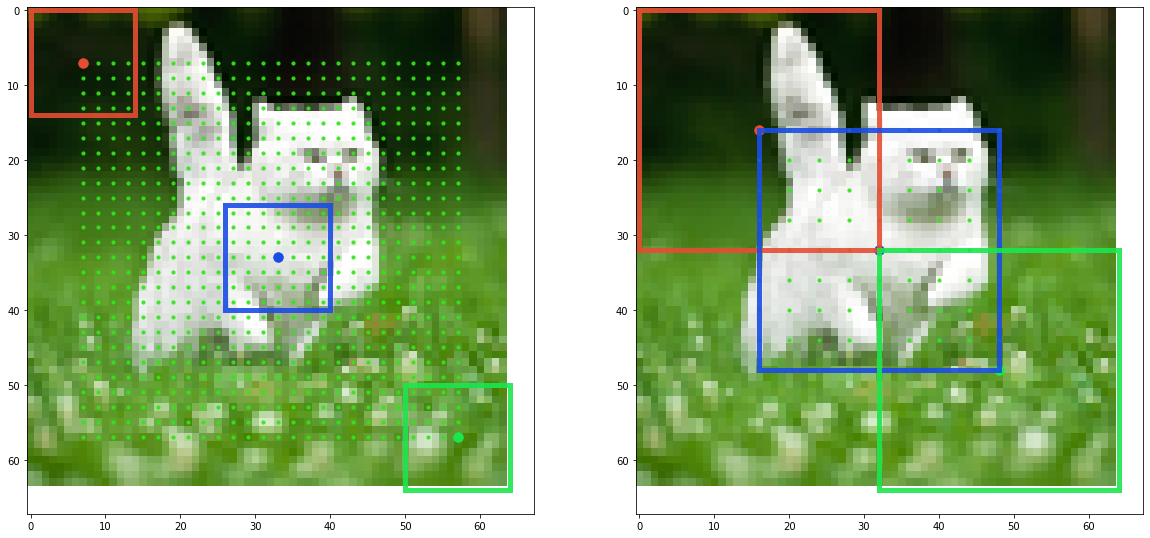

In [109]:
import sys 
import os 
from PIL import Image

from receptivefields.image import get_default_image,tile_pil_image

imgt = Image.open(r"E:\GitHub\SimpleCVReproduction\easy-receptive-fields-pytorch\receptivefield\receptivefields\resources\cat.jpg", mode="r")
imgt = imgt.resize((input_shape[0], input_shape[1]), Image.ANTIALIAS)
imgt = tile_pil_image(imgt, tile_factor=0, shade=True)


rf.plot_rf_grids(imgt, figsize=(20, 12), layout=(1, 2))

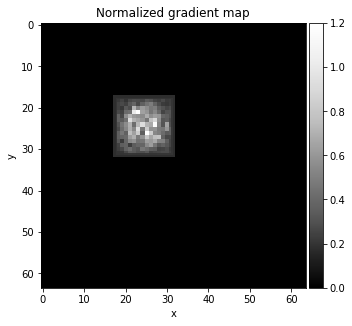

In [110]:
rf.plot_gradient_at(fm_id=0, point=(9, 9))

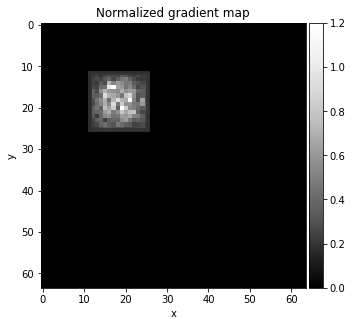

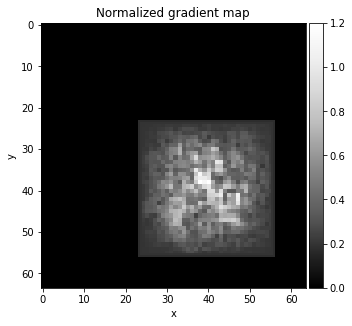

In [111]:
rf.plot_gradient_at(fm_id=0, point=(6, 6))
rf.plot_gradient_at(fm_id=1, point=(6, 6))

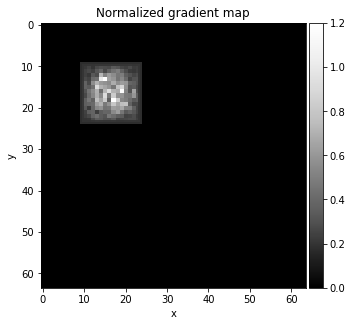

In [112]:
rf.plot_gradient_at(fm_id=0, point=(5, 5))

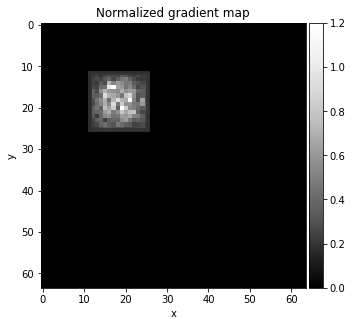

In [113]:
rf.plot_gradient_at(fm_id=0, point=(6, 6))